# Redes Neuronales Convolucionales MxNet

In [ ]:
!nvidia-smi

Wed Nov 16 00:26:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --user mxnet-cu112

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 499.4 MB 1.7 kB/s 


In [38]:
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt

from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.model_zoo import vision


In [39]:
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    transforms.RandomResizedCrop(32),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [40]:
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = 128 

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [41]:
for data,label in train_data:
  break

In [42]:
import matplotlib.pyplot as plt

image=data[1,:].asnumpy().reshape(3,32,32).transpose(1,2,0)

(<matplotlib.image.AxesImage at 0x7fc76f075510>, 
 [2]
 <NDArray 1 @cpu_shared(0)>)

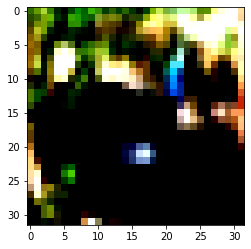

In [44]:
plt.imshow(image),label[1]

# 1.1 Entrenar modelo "from scratch"

Descargamos un modelo desde el repositorio de MxNet.

In [ ]:
# https://mxnet.apache.org/versions/1.9.1/api/python/docs/api/gluon/model_zoo/index.html

model = vision.resnet18_v1(pretrained=False)

In [ ]:
model.collect_params()

resnetv10_ (
  Parameter resnetv10_conv0_weight (shape=(64, 0, 7, 7), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_batchnorm0_gamma (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_batchnorm0_beta (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_batchnorm0_running_mean (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_batchnorm0_running_var (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_stage1_conv0_weight (shape=(64, 64, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_stage1_batchnorm0_gamma (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_stage1_batchnorm0_beta (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_stage1_batchnorm0_running_mean (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_stage1_batchnorm0_running_var (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter resnetv10_stage1_conv1_weight (shape=(64, 64, 3, 3), dtype=<class 'numpy.fl

Inicializamos los parametros en la GPU.

In [ ]:
from mxnet.gluon import nn

ctx=[mx.gpu()]
model.output = nn.Dense(10)
model.initialize(mx.init.Xavier(), ctx = ctx)

In [ ]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# Nesterov accelerated gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.1, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
train_metric = mx.metric.Accuracy()

In [46]:
def test(ctx, model,val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [model(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

In [ ]:
import time 
from mxnet import autograd as ag

epochs = 20
lr_decay_count = 0
train_history=list()
val_accuracy=list()
train_accuracy=list()
for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [model(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asnumpy() for l in loss])
        train_metric.update(label, output)
    train_history.append(train_loss/(i*batch_size))
    name, acc = train_metric.get()
    train_accuracy.append(acc)
    # Evaluate on Validation data
    name, val_acc = test(ctx,model, val_data)
    val_accuracy.append(val_acc)
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))



[Epoch 0] train=0.148177 val=0.225900 loss=154703.140625 time: 40.631672
[Epoch 1] train=0.228626 val=0.272800 loss=125123.421875 time: 39.539554
[Epoch 2] train=0.266647 val=0.319300 loss=119076.085938 time: 36.565133
[Epoch 3] train=0.288842 val=0.356000 loss=115011.906250 time: 44.655553
[Epoch 4] train=0.310998 val=0.358100 loss=111829.289062 time: 36.633148
[Epoch 5] train=0.301402 val=0.357000 loss=112860.976562 time: 35.575439
[Epoch 6] train=0.330148 val=0.381700 loss=108552.492188 time: 37.290272
[Epoch 7] train=0.347937 val=0.390100 loss=105559.031250 time: 35.789214
[Epoch 8] train=0.361599 val=0.408700 loss=103192.296875 time: 36.723151
[Epoch 9] train=0.371414 val=0.400000 loss=100968.609375 time: 36.614420
[Epoch 10] train=0.375240 val=0.434500 loss=100819.750000 time: 37.074393
[Epoch 11] train=0.391526 val=0.457400 loss=98379.328125 time: 38.572261
[Epoch 12] train=0.396334 val=0.460300 loss=97518.734375 time: 34.972316
[Epoch 13] train=0.408333 val=0.465200 loss=95307.

In [ ]:
train_loss

101842.68449401855

# 1.2 Ajuste Fino

In [45]:
finetune_model = vision.resnet18_v1(pretrained=True)

In [47]:
finetune_model.collect_params()

resnetv11_ (
  Parameter resnetv11_conv0_weight (shape=(64, 3, 7, 7), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_batchnorm0_gamma (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_batchnorm0_beta (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_batchnorm0_running_mean (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_batchnorm0_running_var (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_stage1_conv0_weight (shape=(64, 64, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_stage1_batchnorm0_gamma (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_stage1_batchnorm0_beta (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_stage1_batchnorm0_running_mean (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_stage1_batchnorm0_running_var (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter resnetv11_stage1_conv1_weight (shape=(64, 64, 3, 3), dtype=<class '

In [51]:
ctx=[mx.gpu()]
finetune_model.output = nn.Dense(10)
finetune_model.output.initialize(mx.init.Xavier(), ctx = ctx)

In [53]:
finetune_model.collect_params().reset_ctx(ctx)

In [54]:
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(finetune_model.collect_params(), optimizer, optimizer_params)

In [56]:
import time 
from mxnet import autograd as ag

epochs = 20
lr_decay_count = 0
train_history=list()
val_accuracy=list()
train_accuracy=list()
for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [finetune_model(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asnumpy() for l in loss])
        train_metric.update(label, output)
    train_history.append(train_loss/(i*batch_size))
    name, acc = train_metric.get()
    train_accuracy.append(acc)
    # Evaluate on Validation data
    name, val_acc = test(ctx,finetune_model, val_data)
    val_accuracy.append(val_acc)
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

[Epoch 0] train=0.596675 val=0.693200 loss=57345.957031 time: 39.578804
[Epoch 1] train=0.636619 val=0.712400 loss=51393.250000 time: 37.267426


KeyboardInterrupt: ignored